https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
energy = pd.read_csv("energy_dataset.csv")
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [3]:
energy = energy[["time", "total load actual"]]
energy

,time,total load actual
0,2015-01-01 00:00:00+01:00,25385.0
1,2015-01-01 01:00:00+01:00,24382.0
2,2015-01-01 02:00:00+01:00,22734.0
3,2015-01-01 03:00:00+01:00,21286.0
4,2015-01-01 04:00:00+01:00,20264.0
...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0
35060,2018-12-31 20:00:00+01:00,29735.0
35061,2018-12-31 21:00:00+01:00,28071.0
35062,2018-12-31 22:00:00+01:00,25801.0


In [4]:
weather = pd.read_csv("weather_features.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [5]:
# delete non-numerical data
weather_clean = weather.copy()
weather_clean = weather_clean.drop(["weather_id", "weather_main", "weather_description", "weather_icon"], axis=1)
weather_clean

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0


In [6]:
# since there are weather measurements from 4 different cities for each timestamp, take the average of the 4 cities 
weather_clean = weather_clean.groupby(['dt_iso']).mean()
weather_clean


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
dt_iso,,,,,,,,,,,
2015-01-01 00:00:00+01:00,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+01:00,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+01:00,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+01:00,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
2015-01-01 04:00:00+01:00,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
2018-12-31 20:00:00+01:00,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
2018-12-31 21:00:00+01:00,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0


In [75]:
# combine the two dataframes based on the common timestamp
energy_weather = energy.merge(weather_clean, left_on='time', right_on='dt_iso', suffixes=None)
energy_weather

/var/folders/mk/x97yxl6121bfr4x7_4d7xfyc0000gn/T/ipykernel_1123/31642869.py:2: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  energy_weather = energy.merge(weather_clean, left_on='time', right_on='dt_iso', suffixes=None)


,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
35060,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
35061,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0
35062,2018-12-31 22:00:00+01:00,25801.0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0,0.0


In [76]:
# check for missing values
energy_weather.isna().sum()

time                  0
total load actual    36
temp                  0
temp_min              0
temp_max              0
pressure              0
humidity              0
wind_speed            0
wind_deg              0
rain_1h               0
rain_3h               0
snow_3h               0
clouds_all            0
dtype: int64

In [77]:
# delete row with missing value
energy_weather = energy_weather.dropna()
energy_weather

,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
35060,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
35061,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0
35062,2018-12-31 22:00:00+01:00,25801.0,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0,0.0


In [78]:
energy_weather = energy_weather.set_index(energy_weather['time'])
energy_weather

,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+01:00,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+01:00,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+01:00,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
2015-01-01 04:00:00+01:00,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
2018-12-31 20:00:00+01:00,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
2018-12-31 21:00:00+01:00,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0


In [79]:
# change the index to datetime object
energy_weather.index = pd.to_datetime(energy_weather.index, utc=True)
energy_weather

,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
2018-12-31 19:00:00+00:00,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
2018-12-31 20:00:00+00:00,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0


In [80]:
# change the timezone back to UTC +1
energy_weather.index = energy_weather.index.tz_convert(tz='Europe/Berlin')

In [82]:
# drop the timezone info in the index
energy_weather.index = energy_weather.index.tz_localize(tz=None)

,time,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01 00:00:00+01:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,2015-01-01 01:00:00+01:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,2015-01-01 02:00:00+01:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,2015-01-01 03:00:00+01:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,2015-01-01 04:00:00+01:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,2018-12-31 19:00:00+01:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
2018-12-31 20:00:00,2018-12-31 20:00:00+01:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
2018-12-31 21:00:00,2018-12-31 21:00:00+01:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0


In [84]:
# delete the timezone in the datetime column
energy_weather = energy_weather.drop(['time'], axis=1)

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
time,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,24382.0,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,22734.0,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,21286.0,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,20264.0,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,30653.0,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0
2018-12-31 20:00:00,29735.0,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0
2018-12-31 21:00:00,28071.0,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

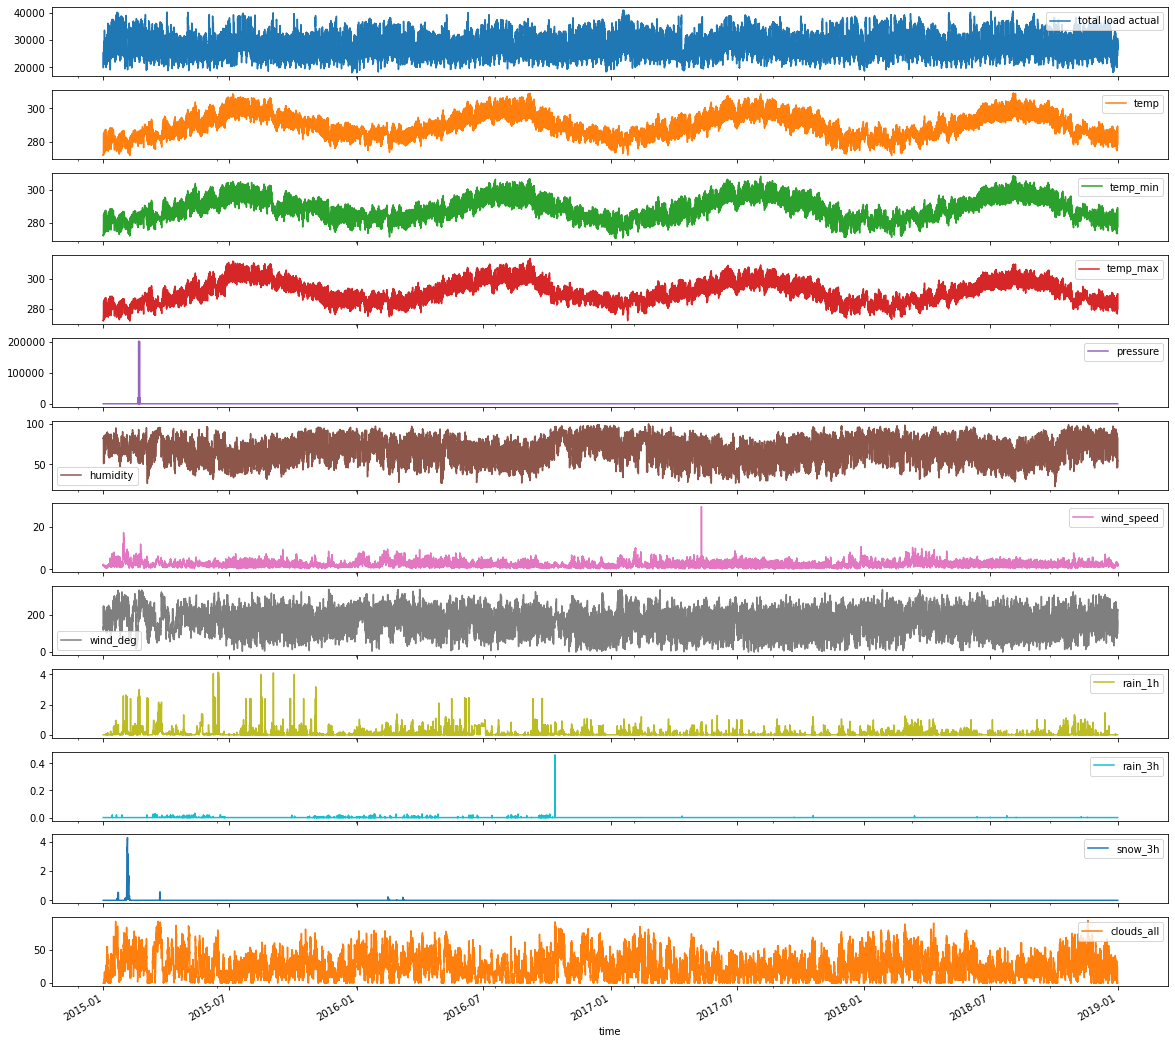

In [85]:
# plot for each column
energy_weather.plot(figsize=(20, 20), subplots=True)

There are some spikes in the plots of non-periodic attributes, e.g. pressure, wind speed, rain_3h and snow_3h. The outliers will be replaced with the mean of the attributes. An outlier is defined as a value higher or lower than twice the standard deviation. 

In [12]:
# define a function to replace outliers (value higher or lower than 2 s.d. from the mean) with the mean
def replace_outlier(column):
    sd = column.std()
    mean = column.mean()
    condition = (abs(column-mean > 2*sd))
    # column = column.mask(condition, median)
    column = np.where(condition, mean, column)
    return column

In [86]:
# apply function to 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h' columns
energy_weather_no_outliers = energy_weather.copy()
energy_weather_no_outliers[['pressure', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h']]= energy_weather_no_outliers[['pressure', 'temp', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h']].apply(replace_outlier)
# energy_weather_no_outliers = energy_weather_no_outliers.apply(replace_outlier)

# # change the unit for temperature from K to C
energy_weather_no_outliers['temp'] = energy_weather_no_outliers['temp'] - 273
energy_weather_no_outliers['temp_min'] = energy_weather_no_outliers['temp_min'] - 273
energy_weather_no_outliers['temp_max'] = energy_weather_no_outliers['temp_max'] - 273
energy_weather_no_outliers.describe()

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
count,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000
mean,28696.939905,16.311676,15.076303,17.758097,1016.455620,68.205106,2.288489,166.577717,0.043102,0.000077,0.004810,24.737151
std,4574.987950,6.831097,6.750128,7.041220,18.797877,14.880423,1.033235,57.472709,0.078926,0.000515,0.101129,17.309523
min,18041.000000,-1.058137,-2.450000,-1.058137,812.400000,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24807.750000,11.064000,9.950000,12.350000,1012.800000,56.800000,1.400000,126.300000,0.000000,0.000000,0.000000,12.000000
50%,28901.000000,16.030300,14.750000,17.550000,1017.000000,69.800000,2.200000,166.000000,0.000000,0.000000,0.000000,22.400000
75%,32192.000000,21.506167,20.150000,23.150000,1021.000000,80.200000,3.000000,207.600000,0.060000,0.000000,0.000000,35.000000
max,41015.000000,31.200000,29.641400,33.154000,2832.000000,98.000000,5.166667,338.000000,0.471429,0.007000,4.300000,93.600000


There are still outliers in the pressure attribute, because the highest pressure recorded is 10084.8 hPa and the lowest pressure is 870 hPa (source: https://en.wikipedia.org/wiki/Atmospheric_pressure). So the outliers are manually selected and replaced with the mean.

In [87]:
# replace pressure higher than world record of 1084.8 with median
energy_weather_no_outliers['pressure'] = energy_weather_no_outliers['pressure'].mask(energy_weather_no_outliers['pressure'] > 1084.4, energy_weather_no_outliers['pressure'].mean())

# replace pressure lower than world record of 870 with median
energy_weather_no_outliers['pressure'] = energy_weather_no_outliers['pressure'].mask(energy_weather_no_outliers['pressure'] < 870, energy_weather_no_outliers['pressure'].mean())

energy_weather_no_outliers.describe()

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
count,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000,35028.000000
mean,28696.939905,16.311676,15.076303,17.758097,1016.312728,68.205106,2.288489,166.577717,0.043102,0.000077,0.004810,24.737151
std,4574.987950,6.831097,6.750128,7.041220,8.492940,14.880423,1.033235,57.472709,0.078926,0.000515,0.101129,17.309523
min,18041.000000,-1.058137,-2.450000,-1.058137,933.200000,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24807.750000,11.064000,9.950000,12.350000,1012.800000,56.800000,1.400000,126.300000,0.000000,0.000000,0.000000,12.000000
50%,28901.000000,16.030300,14.750000,17.550000,1017.000000,69.800000,2.200000,166.000000,0.000000,0.000000,0.000000,22.400000
75%,32192.000000,21.506167,20.150000,23.150000,1021.000000,80.200000,3.000000,207.600000,0.060000,0.000000,0.000000,35.000000
max,41015.000000,31.200000,29.641400,33.154000,1070.267210,98.000000,5.166667,338.000000,0.471429,0.007000,4.300000,93.600000


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

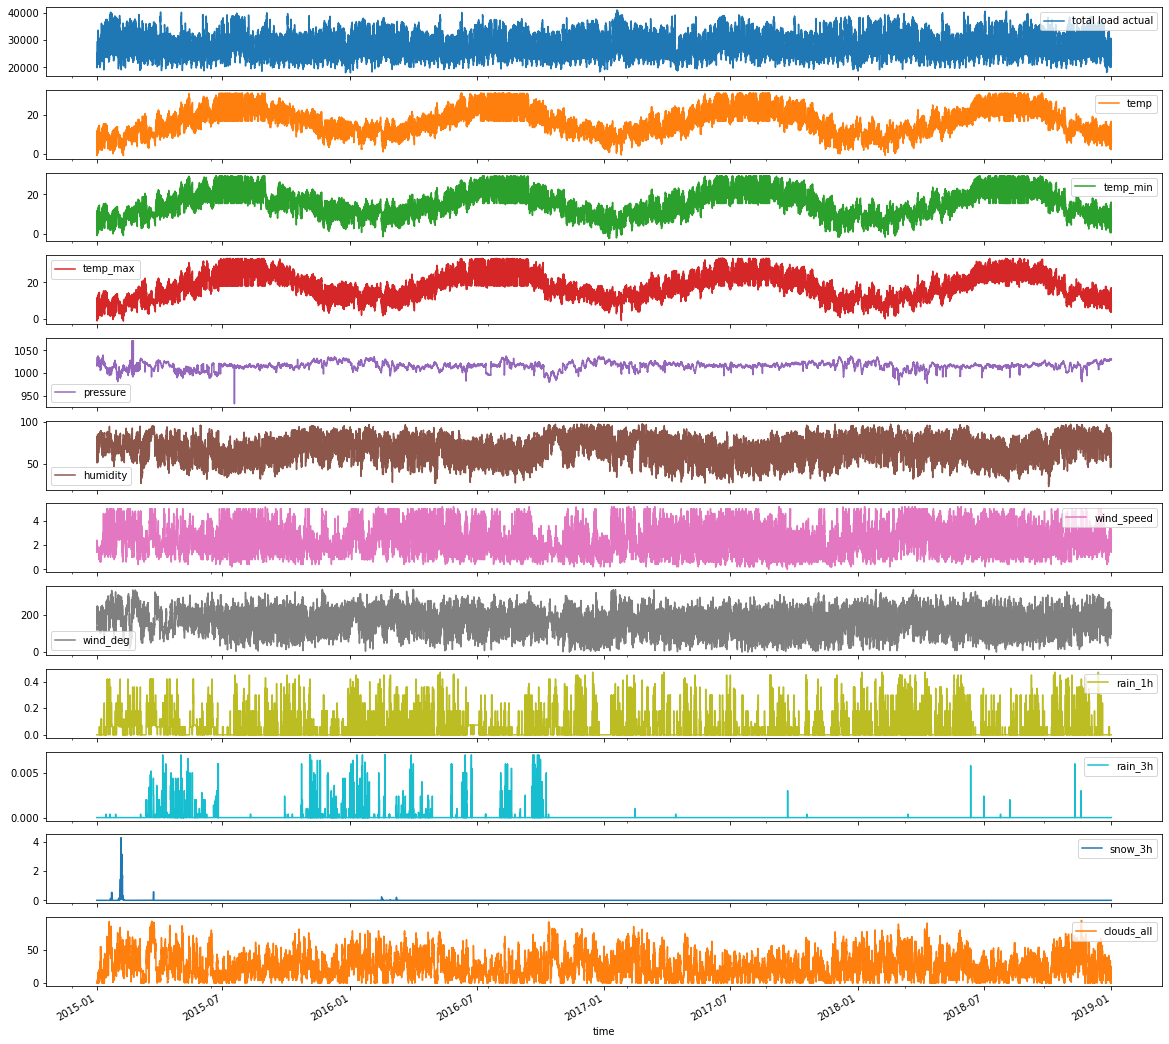

In [88]:
# plot for each column
energy_weather_no_outliers.plot(figsize=(20, 20), subplots=True)

## Remove outliers in the energy consumption column

For the attributes with periodic trends, the outliers are detected using a rolling basis.
The window size is chosen to be 168 (hours), i.e. 7 days.
Same as before, the threshold for classifying an outlier is defined as 2 times the standard deviation.

In [16]:
# code from https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d

def basic_filter(data, mode='rolling', window=168, threshold=2):
    """Basic Filter.
    
    Mark as outliers the points that are out of the interval:
    (mean - threshold * std, mean + threshold * std ).
    
    Parameters
    ----------
    data : pandas.Series
        The time series to filter.
    mode : str, optional, default: 'rolling'
        Whether to filter in rolling or expanding basis.
    window : int, optional, default: 262
        The number of periods to compute the mean and standard
        deviation.
    threshold : int, optional, default: 3
        The number of standard deviations above the mean.
        
    Returns
    -------
    series : pandas.DataFrame
        Original series and marked outliers.
    """
    msg = f"Type must be of pandas.Series but {type(data)} was passed."
    assert isinstance(data, pd.Series), msg
    
    series = data.copy()
    
    # rolling/expanding objects
    pd_object = getattr(series, mode)(window=window)
    mean = pd_object.mean()
    std = pd_object.std()
    
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    outliers = ~series.between(lower_bound, upper_bound)
    # fill false positives with 0
    outliers.iloc[:window] = np.zeros(shape=window)
    
    series = series.to_frame()
    series['outliers'] = np.array(outliers.astype('int').values)
    series.columns = ['Close', 'Outliers']
    
    return series

In [89]:
# check if the energy value is an outlier
energy_outliers = basic_filter(energy_weather_no_outliers['total load actual'])

In [90]:
# add the outlier column to the energy_weather_no_outliers dataframe
energy_weather_no_outliers['outlier'] = energy_outliers['Outliers']
energy_weather_no_outliers

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,outlier
time,,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,0
2015-01-01 01:00:00,24382.0,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,0
2015-01-01 02:00:00,22734.0,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,0
2015-01-01 03:00:00,21286.0,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,0
2015-01-01 04:00:00,20264.0,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,30653.0,11.470000,10.350000,12.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0,0
2018-12-31 20:00:00,29735.0,9.294000,7.950000,10.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0,0
2018-12-31 21:00:00,28071.0,7.850000,7.350000,8.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0,0


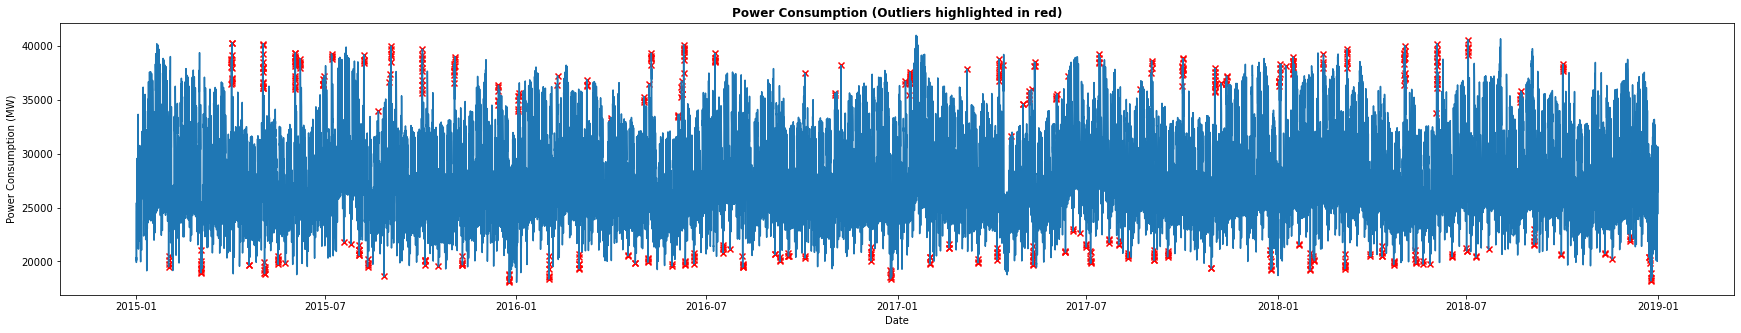

In [92]:
# show the outlier in plot
plt.figure(figsize=(30, 5))
plt.plot(energy_weather_no_outliers["total load actual"])

outliers = energy_weather_no_outliers["outlier"]
plt.scatter(energy_weather_no_outliers.loc[outliers == 1].index, energy_weather_no_outliers.loc[outliers == 1]["total load actual"], c = 'red', marker="x")

plt.xlabel("Date")
plt.ylabel("Power Consumption (MW)")
plt.title("Power Consumption (Outliers highlighted in red)", fontweight="bold")
plt.show()


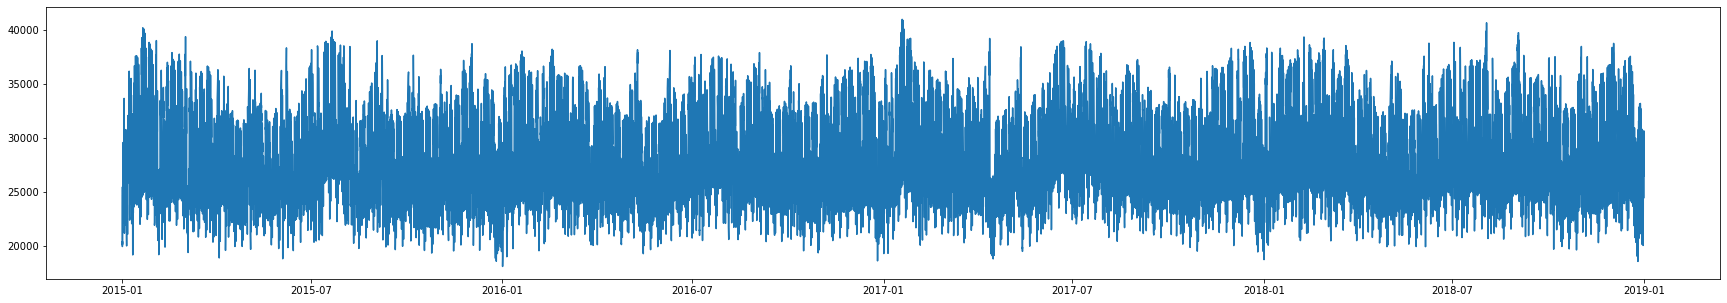

In [93]:
# select only non-outlier data
energy_weather_no_outliers = energy_weather_no_outliers.loc[energy_weather_no_outliers['outlier'] == 0]

# show data after removing outlier
plt.figure(figsize=(30, 5))
plt.plot(energy_weather_no_outliers["total load actual"])

### Remove noise using Fourier Transform

In [94]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [100]:
denoised = fft_denoiser(energy_weather_no_outliers['total load actual'], 85000000)
denoised
energy_weather_no_outliers['denoised_data'] = denoised
energy_weather_no_outliers

/var/folders/mk/x97yxl6121bfr4x7_4d7xfyc0000gn/T/ipykernel_1123/669344355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_weather_no_outliers['denoised_data'] = denoised


,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,outlier,denoised_data
time,,,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,0,23281.632166
2015-01-01 01:00:00,24382.0,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,0,21535.338327
2015-01-01 02:00:00,22734.0,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,0,20201.148331
2015-01-01 03:00:00,21286.0,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,0,19502.224212
2015-01-01 04:00:00,20264.0,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,0,19529.628377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,30653.0,11.470000,10.350000,12.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0,0,28575.173862
2018-12-31 20:00:00,29735.0,9.294000,7.950000,10.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0,0,28563.290094
2018-12-31 21:00:00,28071.0,7.850000,7.350000,8.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0,0,27968.839356


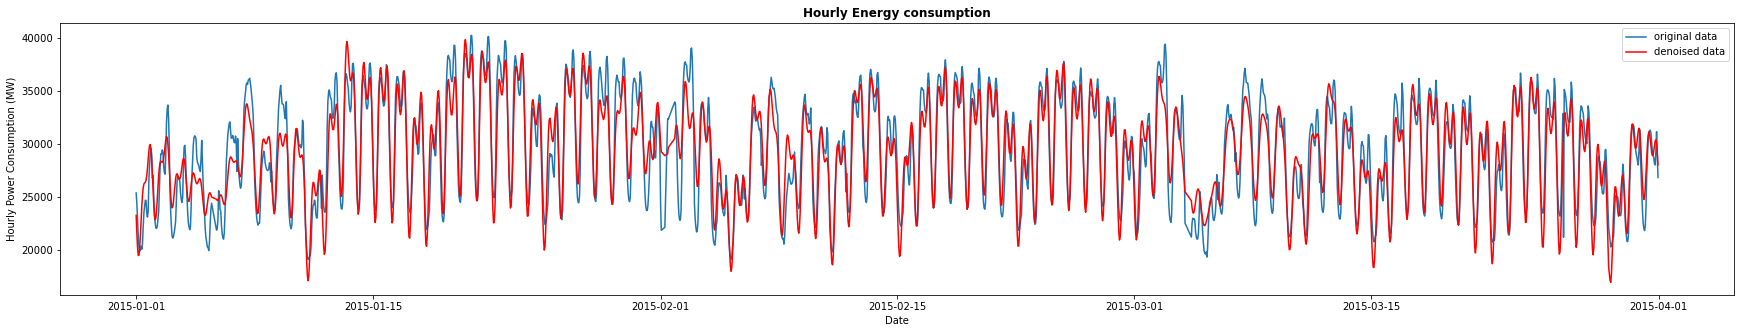

In [101]:
plt.figure(figsize=(30, 5))
plt.plot(energy_weather_no_outliers.loc['2015-01-01':'2015-03-31'].index, energy_weather_no_outliers['total load actual'][:2129], label='original data')
plt.plot(energy_weather_no_outliers.loc['2015-01-01':'2015-03-31'].index, energy_weather_no_outliers['denoised_data'][:2129], color='r', label = "denoised data")


plt.xlabel("Date")
plt.ylabel("Hourly Power Consumption (MW)")

plt.title("Hourly Energy consumption", fontweight="bold")
plt.legend()
plt.show()

In [102]:
energy_weather_no_outliers

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,outlier,denoised_data
time,,,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,0,23281.632166
2015-01-01 01:00:00,24382.0,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,0,21535.338327
2015-01-01 02:00:00,22734.0,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,0,20201.148331
2015-01-01 03:00:00,21286.0,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,0,19502.224212
2015-01-01 04:00:00,20264.0,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,0,19529.628377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,30653.0,11.470000,10.350000,12.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0,0.0,0,28575.173862
2018-12-31 20:00:00,29735.0,9.294000,7.950000,10.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0,0.0,0,28563.290094
2018-12-31 21:00:00,28071.0,7.850000,7.350000,8.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0,0.0,0,27968.839356


In [103]:
# delete the columns 'totaal load actual' and 'outlier'
energy_weather_no_outliers = energy_weather_no_outliers.drop(['total load actual', 'outlier'], axis=1)
energy_weather_no_outliers.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,denoised_data
time,,,,,,,,,,,,
2015-01-01 00:00:00,-0.508537,-0.508537,-0.508537,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,23281.632166
2015-01-01 01:00:00,-0.487300,-0.487300,-0.487300,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,21535.338327
2015-01-01 02:00:00,-0.900863,-0.900863,-0.900863,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,20201.148331
2015-01-01 03:00:00,-0.910531,-0.910531,-0.910531,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,19502.224212
2015-01-01 04:00:00,-0.854100,-0.854100,-0.854100,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,19529.628377


## Split the dataset to training, validation and test set

In [104]:
# split the data into 70% training, 10% validation and 20% test set
# manually split the data to avoid shuffling the data
train_idx = int(len(energy_weather_no_outliers)*0.7)
validation_idx = int(len(energy_weather_no_outliers)*0.8)


train_data = energy_weather_no_outliers.iloc[:train_idx]
validation_data = energy_weather_no_outliers.iloc[train_idx:validation_idx]
test_data = energy_weather_no_outliers.iloc[validation_idx:]

print("training set sample size is", len(train_data))
print("validation set sample size is", len(validation_data))
print("test set sample size is", len(test_data))

print("total sample size is", len(train_data)+ len(validation_data) +len(test_data))

training set sample size is 24142
validation set sample size is 3449
test set sample size is 6898
total sample size is 34489


In [105]:
# standardize data using training set
scaler = MinMaxScaler(feature_range = (0, 1))
scaler = scaler.fit(train_data)

In [106]:
# standardize training set
train_data = pd.DataFrame(scaler.transform(train_data), index=train_data.index, columns=train_data.columns)

In [107]:
# standardize validation set
validation_data = pd.DataFrame(scaler.transform(validation_data), index=validation_data.index, columns=validation_data.columns)
validation_data

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,denoised_data
time,,,,,,,,,,,,
2017-10-20 00:00:00,0.526135,0.542201,0.532213,0.589492,0.620112,0.193548,0.491124,0.000000,0.0,0.0,0.243478,0.437773
2017-10-20 01:00:00,0.511069,0.529737,0.514675,0.595328,0.706704,0.193548,0.455621,0.127273,0.0,0.0,0.347826,0.375729
2017-10-20 02:00:00,0.528801,0.567130,0.508829,0.598247,0.720670,0.348387,0.521302,0.000000,0.0,0.0,0.336957,0.327463
2017-10-20 03:00:00,0.499847,0.517273,0.502983,0.602624,0.765363,0.387097,0.604142,0.127273,0.0,0.0,0.380435,0.304519
2017-10-20 04:00:00,0.477961,0.504808,0.473754,0.602624,0.815642,0.309677,0.517160,0.381818,0.0,0.0,0.347826,0.313416
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-15 11:00:00,0.409079,0.417557,0.421141,0.493189,0.561453,0.477571,0.710059,0.000000,0.0,0.0,0.380435,0.783569
2018-03-15 12:00:00,0.444419,0.454951,0.450371,0.494648,0.466480,0.477571,0.710059,0.000000,0.0,0.0,0.380435,0.778927
2018-03-15 13:00:00,0.485029,0.498576,0.485446,0.497566,0.337989,0.477571,0.715976,0.000000,0.0,0.0,0.304348,0.758369


In [108]:
# standardie test set
test_data = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)
test_data

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,denoised_data
time,,,,,,,,,,,,
2018-03-15 16:00:00,0.513487,0.511040,0.520521,0.493189,0.268156,0.477571,0.727811,0.381818,0.0,0.0,0.260870,0.701021
2018-03-15 17:00:00,0.478209,0.479879,0.479600,0.494648,0.438547,0.477571,0.863905,0.763636,0.0,0.0,0.423913,0.701966
2018-03-15 18:00:00,0.492407,0.523505,0.479600,0.499025,0.452514,0.477571,0.668639,0.509091,0.0,0.0,0.304348,0.709524
2018-03-15 19:00:00,0.451735,0.467415,0.450371,0.501944,0.497207,0.477571,0.745562,0.509091,0.0,0.0,0.380435,0.714988
2018-03-15 20:00:00,0.415837,0.436254,0.415295,0.509239,0.547486,0.890323,0.721893,0.381818,0.0,0.0,0.293478,0.708470
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.388371,0.398861,0.397758,0.700386,0.659218,0.270968,0.447929,0.000000,0.0,0.0,0.000000,0.489998
2018-12-31 20:00:00,0.320916,0.324074,0.333453,0.706223,0.581006,0.348387,0.474556,0.000000,0.0,0.0,0.000000,0.489529
2018-12-31 21:00:00,0.276152,0.305378,0.274994,0.704764,0.628492,0.503226,0.668639,0.000000,0.0,0.0,0.000000,0.466113


In [147]:
# functions to lag the features 
# def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):

#     sequences = []
#     data_size = len(input_data)

#     for i in range(data_size - sequence_length):

#         sequence = input_data[i:i+sequence_length]

#         label_position = i + sequence_length
#         label = input_data.iloc[label_position][target_column]

#         sequences.append((sequence, label))

#     return sequences

# code adapted from https://www.youtube.com/watch?v=jR0phoeXjrc
# function to lag the features
# sequence_length determine the number of record to lag
def create_feature(input_data: pd.DataFrame, sequence_length):

    feature = []
    data_size = len(input_data)

    input_data = input_data.iloc[:, :-1]
    
    for i in range(data_size - sequence_length):
        
        sequence = input_data[i:i+sequence_length]

        feature.append(sequence)

    return feature

# function to lag the labels
def create_label(input_data: pd.DataFrame, target_column, sequence_length):

    labels = []
    data_size = len(input_data)

    for i in range(data_size - sequence_length):

        # sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        labels.append(label)

    return labels

In [148]:
# lag the training set
train_feature = create_feature(train_data, sequence_length=50)
train_label = create_label(train_data, "denoised_data", sequence_length=50)

# lag the validation set
validation_feature = create_feature(validation_data, sequence_length=50)
validation_label = create_label(validation_data, "denoised_data", sequence_length=50)

# lag the test set
test_feature = create_feature(test_data, sequence_length=50)
test_label = create_label(test_data, "denoised_data", sequence_length=50)

In [149]:
print("Length of train_feature is ", str(len(train_feature)))
print("Length of train_label is ", str(len(train_label)))
print("Length of validation_feature is ", str(len(validation_feature)))
print("Length of validation_label is ", str(len(validation_label)))
print("Length of test_feature is ", str(len(test_feature)))
print("Length of test_label is ", str(len(test_label)))


Length of train_feature is  24092
Length of train_label is  24092
Length of validation_feature is  3399
Length of validation_label is  3399
Length of test_feature is  6848
Length of test_label is  6848


In [151]:
# convert the training_feature list to tensor
import torch
X_train = torch.tensor(np.array(train_feature), dtype=torch.float)

# flatten the tensor
X_train = torch.flatten(X_train, start_dim=1)
print("The shape of the X_train tensor is ", str(X_train.shape))

The shape of the X_train tensor is  torch.Size([24092, 550])


In [152]:
# convert the training_label list to tensor
y_train = torch.FloatTensor(train_label)

print("The shape of the y_train tensor is ", str(y_train.shape))

The shape of the y_train tensor is  torch.Size([24092])


In [153]:
# convert the validation_feature list to tensor
X_validation = torch.tensor(np.array(validation_feature), dtype=torch.float)

# flatten the tensor
X_validation = torch.flatten(X_validation, start_dim=1)
print("The shape of the X_validation tensor is ", str(X_validation.shape))

The shape of the X_validation tensor is  torch.Size([3399, 550])


In [154]:
# convert the training_label list to tensor
y_validation = torch.FloatTensor(validation_label)

print("The shape of the y_validation tensor is ", str(y_validation.shape))

The shape of the y_validation tensor is  torch.Size([3399])


In [155]:
# convert the test_feature list to tensor
X_test = torch.tensor(np.array(test_feature), dtype=torch.float)

# flatten the tensor
X_test = torch.flatten(X_test, start_dim=1)
print("The shape of the X_test tensor is ", str(X_test.shape))

The shape of the X_test tensor is  torch.Size([6848, 550])


In [156]:
# convert the test_label list to tensor
y_test = torch.FloatTensor(test_label)

print("The shape of the y_test tensor is ", str(y_test.shape))

The shape of the y_test tensor is  torch.Size([6848])


### Check whether it is running on CPU or GPU

In [158]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## MLP
### Simple MLP 

In [165]:
# template for MLP from lab 02

class TimeNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(TimeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

In [174]:
mlp_model = TimeNN(input_size = X_train.shape[1], hidden_dim = 100, output_size=1)    # get an instance of the MLP NN

In [175]:
lr = 0.1    # learning rate
n_epoch = 100
criterion = nn.MSELoss()    # specify loss function
optimizer = torch.optim.SGD(mlp_model.parameters(), lr)   # optimise using stochastic gradient descent

In [176]:
mlp_model.eval()    # enter evaluation mode
y_pred = mlp_model(X_validation)     # obtain predicted value
before_train = criterion(y_pred.squeeze(), y_validation)    # compare predicted and target value using the criterion 
print('Train loss before training' , before_train.item())    

Train loss before training 0.40233275294303894


In [177]:
mlp_model.train()  # enter train mode

for epoch in range(n_epoch):
    optimizer.zero_grad()   # reset gradient
    y_pred = mlp_model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    if epoch%10 == 0:
        print('Epoch {}/{} - Loss: {}'.format(epoch, n_epoch, loss.item()))

Epoch 0/100 - Loss: 0.3428131937980652
Epoch 10/100 - Loss: 0.06411170959472656
Epoch 20/100 - Loss: 0.025613613426685333
Epoch 30/100 - Loss: 0.025171520188450813
Epoch 40/100 - Loss: 0.025166209787130356
Epoch 50/100 - Loss: 0.02516590990126133
Epoch 60/100 - Loss: 0.02516566775739193
Epoch 70/100 - Loss: 0.02516542375087738
Epoch 80/100 - Loss: 0.02516518160700798
Epoch 90/100 - Loss: 0.02516493946313858


In [178]:
mlp_model.eval()    # enter evaluation mode
y_pred = mlp_model(X_validation)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation)    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.028216270729899406


### MLP with momentum term

In [171]:
# reshape the output tensor from 1D to 2D
y_train_2D = y_train[:, None]
print(y_train_2D.shape)

y_validation_2D = y_validation[:, None]
print(y_validation_2D.shape)

torch.Size([24092, 1])
torch.Size([3399, 1])


In [179]:
torch.manual_seed(0)

# create a Skorch NeuralNet for regression
net = NeuralNetRegressor(module = mlp_model, lr = 0.1, max_epochs = 100, 
                        optimizer=torch.optim.SGD, optimizer__momentum=0.95, 
                        train_split=False, verbose=0)  

net.fit(X_train, y_train_2D)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TimeNN(
    (fc1): Linear(in_features=550, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

In [180]:
from sklearn.metrics import mean_squared_error
y_pred = net.predict(X_validation)
mean_squared_error(y_pred, y_validation)   # compare predicted and target value using the criterion 

0.022801513

Comment: The mean squared error has decreased from 0.0282 to 0.0228. Adding a momentum term improves the performance of the MLP.

### Tuning hyperparameters with grid search and cross validation

In [63]:
# time series cross validation for time series data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10, test_size=240, gap = 100)

In [64]:
from sklearn.model_selection import GridSearchCV
params = {'lr': [0.01, 0.05, 0.1, 0.2, 0.5],
        'max_epochs': [20, 40],
        'optimizer': [torch.optim.SGD, torch.optim.Adam]}

gs = GridSearchCV(net, params, scoring='neg_mean_squared_error', refit=False, cv=tscv, verbose=0)
gs.fit(X_train, y_train_2D)
print(gs.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.4s
[CV 2/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.5s
[CV 3/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 4/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 5/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 6/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.8s
[CV 7/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.8s
[CV 8/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 9/10] END lr=0.01, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 10/10] END lr=0.01, max_epochs=20, optimizer=<class

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  10.9s
[CV 2/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.0s
[CV 3/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.1s
[CV 4/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.2s
[CV 5/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.3s
[CV 6/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.4s
[CV 7/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.5s
[CV 8/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.7s
[CV 9/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.9s
[CV 10/10] END lr=0.01, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.6s
[CV 1/10] END lr=0.

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 2/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 3/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 4/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 5/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 6/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 7/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.2s
[CV 8/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 9/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 10/10] END lr=0.05, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 1/10] END lr=0.

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.5s
[CV 2/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.5s
[CV 3/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.5s
[CV 4/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.8s
[CV 5/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.8s
[CV 6/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.1s
[CV 7/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.7s
[CV 8/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.0s
[CV 9/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.8s
[CV 10/10] END lr=0.05, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.8s
[CV 1/10] END lr=0.

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.5s
[CV 2/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.5s
[CV 3/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 4/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 5/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.8s
[CV 6/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 7/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 8/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 9/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 10/10] END lr=0.1, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 1/10] END lr=0.1, max_epo

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.0s
[CV 2/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  10.9s
[CV 3/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.2s
[CV 4/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.1s
[CV 5/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.3s
[CV 6/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.4s
[CV 7/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.7s
[CV 8/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.6s
[CV 9/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.8s
[CV 10/10] END lr=0.1, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.9s
[CV 1/10] END lr=0.1, max_epo

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.5s
[CV 2/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 3/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 4/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 5/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.7s
[CV 6/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.8s
[CV 7/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.4s
[CV 8/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 9/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.1s
[CV 10/10] END lr=0.2, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.1s
[CV 1/10] END lr=0.2, max_epo

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.0s
[CV 2/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.0s
[CV 3/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.2s
[CV 4/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.4s
[CV 5/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.4s
[CV 6/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.4s
[CV 7/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.6s
[CV 8/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.7s
[CV 9/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.7s
[CV 10/10] END lr=0.2, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.8s
[CV 1/10] END lr=0.2, max_epo

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 2/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.6s
[CV 3/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 4/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 5/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.0s
[CV 6/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.1s
[CV 7/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.1s
[CV 8/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.1s
[CV 9/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   5.9s
[CV 10/10] END lr=0.5, max_epochs=20, optimizer=<class 'torch.optim.sgd.SGD'>; total time=   6.2s
[CV 1/10] END lr=0.5, max_epo

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

[CV 1/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.2s
[CV 2/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.1s
[CV 3/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.2s
[CV 4/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.6s
[CV 5/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.2s
[CV 6/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.4s
[CV 7/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.3s
[CV 8/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.4s
[CV 9/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  11.9s
[CV 10/10] END lr=0.5, max_epochs=40, optimizer=<class 'torch.optim.sgd.SGD'>; total time=  12.6s
[CV 1/10] END lr=0.5, max_epo

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 1233, in fit
    self.initialize()
  File "/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/skorch/net.py", line 822, in initialize
    self._initialize_optimizer()
  File

In [71]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs.best_params_, -gs.best_score_))
gs.best_params_

Result of grid search returns the best model as {'lr': 0.05, 'max_epochs': 20, 'optimizer': <class 'torch.optim.sgd.SGD'>} with a mean squared error of 0.000492


{'lr': 0.05, 'max_epochs': 20, 'optimizer': torch.optim.sgd.SGD}

In [73]:
gs.best_params_

{'lr': 0.05, 'max_epochs': 20, 'optimizer': torch.optim.sgd.SGD}

In [76]:
net_best = NeuralNetRegressor(module = mlp_model, lr = 0.05, max_epochs = 20, 
                        optimizer=torch.optim.SGD, optimizer__momentum=0.95, 
                        train_split=False, verbose=0)  

net.fit(X_validation, y_validation_2D)

y_pred = net.predict(X_validation)
mean_squared_error(y_pred, y_validation)  


0.009106425

## RNN

In [119]:
# reshape the output tensor from 1D to 2D
X_train_3D = X_train[:, None]
print(X_train_3D.shape)

# reshape the output tensor from 1D to 2D
X_validation_3D = X_validation[:, None]
print(X_validation_3D.shape)

torch.Size([24092, 1, 500])
torch.Size([3399, 1, 500])


In [120]:
X_validation.shape

torch.Size([3399, 500])

In [115]:
# code from tutorial 10
batch_size = 64

class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(RNN, self).__init__()

        # define some parameters
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # define the layers
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers, batch_first= True)    # RNN layer
        self.fc = nn.Linear(hidden_dim, output_size)   # fully connected layer
    
    def forward(self, x):
        batch_size = X_train.shape[0]
        
        # initialize hidden state for first input 
        hidden = self.init_hidden(batch_size)

        # pass the input and hidden state into the model to get output
        out, hidden = self.rnn(x, hidden)

        # reshape the output such that it can be fit into fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)

        return out, hidden
    
    def init_hidden(self, batch_size):
        # generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
         # send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [88]:
y_train_2D.shape[1]

1

In [118]:
# Instantiate the model with hyperparameters
model = RNN(input_size=X_train.shape[1], output_size=y_train_2D.shape[1], hidden_dim=12, num_layers=1)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 100
lr=0.01
batch_size = 64

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [117]:
# Training Run
X_train = X_train.to(device)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(X_train)
    output = output.to(device)
    target_seq = target_seq.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

RuntimeError: input must have 3 dimensions, got 2

### LSTM

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)